# INSTALLING AND IMPORTING LIBRARIES
# ADD CUSTOM STOPWORDS TO NLTK DEFAULT STOPWORD LIST
# DATA PRE-PROCESSING# TEST-TRAIN SPLIT AND MODELLING
# TEST-TRAIN SPLIT AND MODELLING
# MAKE EMBEDING LAYER USING GLOVE VECTOR
# DECIDE LSTM ARCHITECTURE
# TRAINING MODEL AND TESTING IT
# MODEL EVALUATION ON TEST SET AND ON A RANDOM OBSERVATION
# SAVING THE MODEL AND LOADING IT FOR LATER USE
# SOME IMPORTANT PRACTICAL ASPECTS

# INSTALLING AND IMPORTING LIBRARIES

In [165]:
#!pip  install textblob
#!pip  install wordcloud

In [ ]:
!pip freeze > requirements_LSTM.txt

In [166]:
# import miscelleneous libraries
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from textblob import Word
import wordcloud
# Importing Tensorflow
import tensorflow as tf
from tensorflow import keras
# import from keras
#import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Activation, Dropout, Dense, Input,SpatialDropout1D
from keras.models import Sequential
from keras.datasets import imdb
from keras.models import load_model
# from sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
#nltk and related libraries
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from textblob import Word
from nltk.tokenize import word_tokenize
# Import libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# Suppress future warnings
import warnings
warnings.filterwarnings('ignore')


# ADD CUSTOM STOPWORDS TO NLTK DEFAULT STOPWORD LIST

In [167]:
# PrintNLTK default stopword list
print(stopwords.words('english'))
len(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

In [168]:
custom_stopwords = [ "could","he'd", "he'll", "he's",  "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's","ought",
                     "she'd", "she'll", "that's", "there's","they'd", "they'll", "they're", "they've", "we'd", "we'll",
                     "we're", "we've", "what's", "when's", "where's", "who's", "why's", "without", "would"]
len(custom_stopwords)  

31

In [169]:
# add custom list to default stopword list of nltk
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(custom_stopwords)
len(stpwrd)

210

In [170]:
mydata = pd.read_csv('G:\\DATA_SETS\\SENTIMENT_ANALYSIS_LSTM\\IMDB_Dataset.csv')

# DATA PRE-PROCESSING

In [ ]:
print(type(mydata))

In [171]:
mydata.shape

(50000, 2)

In [172]:
mydata.head()         
# We see html tags like  <br /><br />   in 'review' column

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [173]:
mydata.tail()           # We see that 'review' column contains mixed case entries

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [174]:
# Converting 'review' column to lower case
mydata['review'] = mydata['review'].str.lower()

In [175]:
mydata.head()           # Now all reviews are in lower case

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [176]:
mydata.describe()          
# There are duplicates. But we decide to keep them 
# Target variable 'sentiment' can be binarised

,review,sentiment
count,50000,50000
unique,49582,2
top,loved today's show!!! it was a variety and not...,positive
freq,5,25000


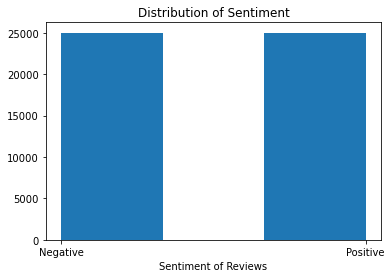

In [177]:
# Visualise data
plt.hist(mydata.sentiment, bins = 3)
plt.xticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Sentiment of Reviews')
plt.title('Distribution of Sentiment')
plt.show()
# Reviews are nicely balanced

In [178]:
print (mydata.sentiment.value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [182]:
mydata.dtypes
# Both columns of type object/string

review       object
sentiment    object
dtype: object

In [183]:
# Check for null values 
mydata.isnull().sum()
# No nulls

review       0
sentiment    0
dtype: int64

In [184]:
# Removing stopwords from 'review' column. Adds a new column 'review_nosw'
def remove_stpwrd(data):
    data['review_nosw'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stpwrd)]))
    return data

In [185]:
# Call above defined function    [ takes about 25-30 seconds]
mydata = remove_stpwrd(mydata)

In [186]:
mydata.tail()
# Comparing 'review' column and 'review_nosw' column we see
# stopwords removed from 'review_nosw' column

,review,sentiment,review_nosw
49995,i thought this movie did a down right good job...,positive,thought movie right good job. creative origina...
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...
49998,i'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...
49999,no one expects the star trek movies to be high...,negative,"one expects star trek movies high art, fans ex..."


In [187]:
# for column 'review_nosw' remove html tags such as <br /><br />
mydata['review_no_sw_Tag'] = mydata['review_nosw'].str.replace(r'<[^<>]*>', '', regex=True)

In [188]:
mydata.head()
# Comparing 'review_nosw' column  and 'review_nosw_Tag' column
# we see html Tags removed in 'review_nosw_Tag' column

,review,sentiment,review_nosw,review_no_sw_Tag
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production. the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy (jake) thinks zomb...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...","petter mattei's ""love time money"" visually stu..."


In [189]:
# Drop 'review' and 'review_nosw' columns
mydata.drop(['review', 'review_nosw'], axis = 1, inplace = True) 

In [190]:
mydata.head()

,sentiment,review_no_sw_Tag
0,positive,one reviewers mentioned watching 1 oz episode ...
1,positive,wonderful little production. the filming techn...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically family little boy (jake) thinks zomb...
4,positive,"petter mattei's ""love time money"" visually stu..."


In [191]:
# Remove numbers from 'review_no_sw_Tag' colum
mydata['review_no_sw_Tag_Num'] = mydata['review_no_sw_Tag'].str.replace('\d+', '')
mydata.head()
# number 1 removed from 'review_no_sw_Tag' column

,sentiment,review_no_sw_Tag,review_no_sw_Tag_Num
0,positive,one reviewers mentioned watching 1 oz episode ...,one reviewers mentioned watching oz episode h...
1,positive,wonderful little production. the filming techn...,wonderful little production. the filming techn...
2,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,negative,basically family little boy (jake) thinks zomb...,basically family little boy (jake) thinks zomb...
4,positive,"petter mattei's ""love time money"" visually stu...","petter mattei's ""love time money"" visually stu..."


In [192]:
# Drop 'review_no_sw_Tag' column
mydata.drop(['review_no_sw_Tag'], axis = 1, inplace = True) 
mydata.head()

,sentiment,review_no_sw_Tag_Num
0,positive,one reviewers mentioned watching oz episode h...
1,positive,wonderful little production. the filming techn...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically family little boy (jake) thinks zomb...
4,positive,"petter mattei's ""love time money"" visually stu..."


In [193]:
# Define the function to remove the punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
# Apply above function  to the column 'review_no_sw_Tag_Num'
mydata['review_no_sw_Tag_Num_Pun'] = mydata['review_no_sw_Tag_Num'].apply(remove_punctuations)
mydata.head()

,sentiment,review_no_sw_Tag_Num,review_no_sw_Tag_Num_Pun
0,positive,one reviewers mentioned watching oz episode h...,one reviewers mentioned watching oz episode h...
1,positive,wonderful little production. the filming techn...,wonderful little production the filming techni...
2,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zombie...
4,positive,"petter mattei's ""love time money"" visually stu...",petter matteis love time money visually stunni...


In [194]:
# Tokenize 'review_no_sw_Tag_Num' colum and create column 'review'
# as cleaning is completed now [ Takes 40-45 seconds]
mydata['review'] = mydata['review_no_sw_Tag_Num_Pun'].apply(word_tokenize) 
mydata.head()

,sentiment,review_no_sw_Tag_Num,review_no_sw_Tag_Num_Pun,review
0,positive,one reviewers mentioned watching oz episode h...,one reviewers mentioned watching oz episode h...,"[one, reviewers, mentioned, watching, oz, epis..."
1,positive,wonderful little production. the filming techn...,wonderful little production the filming techni...,"[wonderful, little, production, the, filming, ..."
2,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,..."
4,positive,"petter mattei's ""love time money"" visually stu...",petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,..."


In [195]:
# Drop columns 'review_no_sw_Tag_Num' and rename 'review_no_sw_Tag_Num_Pun' to 'reviews'
mydata.drop(['review_no_sw_Tag_Num'], axis=1, inplace=True)
mydata.rename(columns={'review_no_sw_Tag_Num_Pun': 'reviews'},inplace=True, errors='raise')
mydata.head()


,sentiment,reviews,review
0,positive,one reviewers mentioned watching oz episode h...,"[one, reviewers, mentioned, watching, oz, epis..."
1,positive,wonderful little production the filming techni...,"[wonderful, little, production, the, filming, ..."
2,positive,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,negative,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,..."
4,positive,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,..."


In [196]:
###################################################################################################################
# Each entry in the 'review' column is a list of many comma separated word. We use this column for wordcloud
# The 'reviews' column contains individual reviews as each record which we will use for building text corpus
###################################################################################################################
# Visualizing the common words in the 'review' column
text = " ".join(review for review in mydata.review.astype(str))

In [197]:
# The size of each word represents its frequency of occurrence in the data
wordcloud = wordcloud.WordCloud().generate(text)   # Takes 60-65 seconds

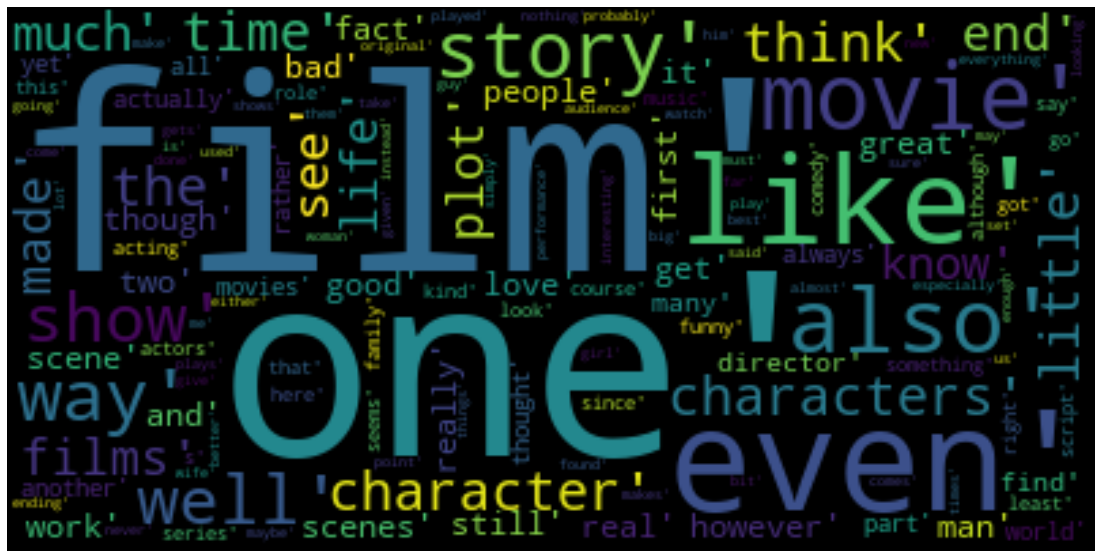

In [198]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# The purpose of making this word_cloud is we can add to custom_stopwords, words such as:  film,film's, movie,movies', time, 
# character,even,also, show,made,the, this,however',part',characters', say,go, find, still, another, story'
# think, end,plot,scenes',director',yet',and',  etc. which are 'neutral' and do not contribute to 
# positiveness or negativeness of review. This makes training and tessting shorter in duration and
# model compact in size

In [202]:
# Encoding the target variable 'sentiment' to '1' for 'positive' and '0' for 'negative'
lb=LabelBinarizer()
mydata['sentiment'] = lb.fit_transform(mydata['sentiment'])
mydata.head()

,sentiment,reviews,review
0,1,one reviewers mentioned watching oz episode h...,"[one, reviewers, mentioned, watching, oz, epis..."
1,1,wonderful little production the filming techni...,"[wonderful, little, production, the, filming, ..."
2,1,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,0,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,..."
4,1,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,..."


In [203]:
# See first/ 0th and last row of 'reviews' column
print(mydata['reviews'][0])
print('---------------------------------------------------------------')
print(mydata['reviews'][len(mydata)-1])

one reviewers mentioned watching  oz episode hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready it watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away it well mannered middle class inmates turned pr

In [204]:
# We want to collect all reviews  as combined text in  single big list
reviews = mydata['reviews']
reviews

0        one reviewers mentioned watching  oz episode h...
1        wonderful little production the filming techni...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: reviews, Length: 50000, dtype: object

In [212]:
reviews_text_corpus = []
for i in range(len(reviews)):
    reviews_text_corpus.append(reviews[i])

In [213]:
reviews_text_corpus   # Now reviews_text_corpus is a list of all words in all reviews

['one reviewers mentioned watching  oz episode hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready it watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away it well mannered middle class inmates turned 

In [210]:
# Convert sentiment column into numpy array
sentiments = mydata['sentiment'].values
sentiments

array([1, 1, 1, ..., 0, 0, 0])

# TEST-TRAIN SPLIT AND MODELLING

In [215]:
X_train, X_test,Y_train, Y_test = train_test_split(reviews_text_corpus, sentiments, test_size=0.2, random_state = 45)
# sanity check
mydata.shape[0] == Y_train.shape[0] + Y_test.shape[0]      
# Sum of number of rows in train and test equals original data

True

In [222]:
print(X_train[1111])
print('-----------------------------------------------------')
print(Y_train[1111])
print('-----------------------------------------------------')
print(X_test[958])
print('-----------------------------------------------------')
print(Y_test[958])
print('-----------------------------------------------------')

inspired hitchcocks strangers train concept two men swapping murders exchange getting rid two people messing lives throw momma train original inventive comedy take idea credit danny devito wrote starred minor comedy gemanne ramsey mother inspires films title understandable gets skin danny devito sharp tongue relentlessly putting minor infraction billy crystal writer wife stolen book idea lionized great new author even appearing oprah show bask adulation enjoying thus devito gets idea swapping murders rid nuisance factorsof course everything anything happen writer carl reiner lets imagination roam unending ideas plot develops amusing way through providing plenty laughs chuckles along way well good deal suspensefor devotees black comedy one guaranteed please
-----------------------------------------------------
1
-----------------------------------------------------
spoiler alert  although think one spoiled coming hard even imagine film stars studio made time period awful is films bigge

In [223]:
# BASELINE ACCURACY:
# baseline accuracy is the proportion of the majority class.
# In this case '1' which is positive sentiment is majority
# SO BA = (no of records with sentiment '1' / total no of records)
BA = len(mydata[mydata['sentiment']==1]) / len(mydata)
BA                    
# 50%

0.5

In [224]:
# X-train is a list of lists, each containing many words
# So we find total words in X_train as below
count = 0
for list in X_train:
    count = count + len(list)
print(count)   # 47,31,160 words but not all will be unique

33382355


In [227]:
# Tokenizing train-set. Tokenizer assigns a unique index to each word
# Thus it creates a dictionary mapping of words
# Initalize Tokenizer assuming 10000         # approx 20% of 'count' found above
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index
len(words_to_index)  # 1,86,920

186920

In [228]:
words_to_index
#words_to_index is a dictionary mapping words to their respective index.

{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'good': 5,
 'even': 6,
 'time': 7,
 'really': 8,
 'see': 9,
 'story': 10,
 'it': 11,
 'much': 12,
 'well': 13,
 'get': 14,
 'great': 15,
 'bad': 16,
 'people': 17,
 'also': 18,
 'first': 19,
 'movies': 20,
 'made': 21,
 'films': 22,
 'make': 23,
 'way': 24,
 'characters': 25,
 'think': 26,
 'watch': 27,
 'many': 28,
 'seen': 29,
 'character': 30,
 'two': 31,
 'never': 32,
 'love': 33,
 'acting': 34,
 'best': 35,
 'plot': 36,
 'little': 37,
 'know': 38,
 'show': 39,
 'the': 40,
 'ever': 41,
 'life': 42,
 'better': 43,
 'say': 44,
 'still': 45,
 'end': 46,
 'scene': 47,
 'man': 48,
 'scenes': 49,
 'something': 50,
 'go': 51,
 'back': 52,
 'real': 53,
 'thing': 54,
 'watching': 55,
 'actors': 56,
 'years': 57,
 'funny': 58,
 'actually': 59,
 'though': 60,
 'makes': 61,
 'another': 62,
 'nothing': 63,
 'find': 64,
 'look': 65,
 'new': 66,
 'going': 67,
 'work': 68,
 'lot': 69,
 'every': 70,
 's': 71,
 'old': 72,
 'us': 73,
 'part': 74,
 'can

In [229]:
# write a function to read the contents of the GloVe Vector file, which
# returns us a dictionary that maps the words to their respective word embeddings.
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [230]:
# Define a variable max_len to keep length of all reviews same [ Takes 25 seconds]
max_len= 200
word_to_vec_map = read_glove_vector('G:\\DATA_SETS\\SENTIMENT_ANALYSIS_LSTM\\glove.6B.50d.txt')

In [232]:
# DEFINE EMBEDDING MATRIX IN WHICH ALL WORDS
# WHICH ARE NOT IN GLOVE DICTIONARY ARE ASSIGNED 0 VALUE
vocab_len = len(words_to_index)           # Size of dictionary produced by tokenizer
embed_vector_len = word_to_vec_map['moon'].shape[0]
embedding_matrix = np.zeros((vocab_len, embed_vector_len))
for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector

In [233]:
# The embedding layer maps words to their embedding-vectors from the embedding matrix.
# We can also define embedding-layer using Keras and keep this layer as trainable,
# which will learn word embedding itself but as we are using GloVe Embeddings, we keep trainable = False
embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=max_len, weights = [embedding_matrix], trainable=False)

In [234]:
# embedding_layer is used to define model architecture
def imdb_rating(input_shape):
    # We use the embedding layer to map the words to their GloVe vectors
    X_indices = Input(input_shape)
    # Then those vectors are input to the LSTM layers
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    # Finally followed by a Dense layer with ‘sigmoid’ activation
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

# TRAINING MODEL AND TESTING IT

In [235]:
# convert reviews in X_train to their index form using 'texts_to_sequences' function from tokenizer
X_train_indices = tokenizer.texts_to_sequences(X_train)
# Now pad sequences so all of them have the same length.
X_train_indices = pad_sequences(X_train_indices, maxlen=max_len, padding='post')

In [236]:
model = imdb_rating(max_len)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 50)           9346000   
                                                                 
 lstm_9 (LSTM)               (None, 200, 128)          91648     
                                                                 
 dropout_6 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 200, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               1315

In [238]:
# Starting actual training with keras Adam we will use version of Adam adapted for tensorflow
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)                       
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_indices, Y_train, batch_size=32, epochs=5)                 
####################################################################################################
# Epoch 1/5
# 1250/1250 [==============================] - 845s 673ms/step - loss: 0.5694 - accuracy: 0.7090
# Epoch 2/5
# 1250/1250 [==============================] - 1017s 814ms/step - loss: 0.4827 - accuracy: 0.7721
# Epoch 3/5
# 1250/1250 [==============================] - 667s 533ms/step - loss: 0.4410 - accuracy: 0.7984
# Epoch 4/5
# 1250/1250 [==============================] - 704s 563ms/step - loss: 0.4097 - accuracy: 0.8162
# Epoch 5/5
# 1250/1250 [==============================] - 899s 719ms/step - loss: 0.3923 - accuracy: 0.8268
# <keras.callbacks.History at 0x27e0ec5bf40>
####################################################################################################


Epoch 1/5
1250/1250 [==============================] - 845s 673ms/step - loss: 0.5694 - accuracy: 0.7090
Epoch 2/5
1250/1250 [==============================] - 1017s 814ms/step - loss: 0.4827 - accuracy: 0.7721
Epoch 3/5
1250/1250 [==============================] - 667s 533ms/step - loss: 0.4410 - accuracy: 0.7984
Epoch 4/5
1250/1250 [==============================] - 704s 563ms/step - loss: 0.4097 - accuracy: 0.8162
Epoch 5/5
1250/1250 [==============================] - 899s 719ms/step - loss: 0.3923 - accuracy: 0.8268


In [239]:
# Testing model on testdataset
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=max_len, padding='post')

# MODEL EVALUATION ON TEST SET AND ON A RANDOM OBSERVATION

In [240]:
model.evaluate(X_test_indices, Y_test)
#313/313 [==============================] - 148s 467ms/step - loss: 0.4131 - accuracy: 0.8145
###################################################################################################
# Thus we get 82.6% accuracy on train data and 81.4% accuracy on test data indicating 
# that this is a good model and there is no over-fitting.
###################################################################################################

313/313 [==============================] - 148s 467ms/step - loss: 0.4131 - accuracy: 0.8145


[0.41306963562965393, 0.8144999742507935]

# SAVING THE MODEL AND LOADING IT FOR LATER USE

In [241]:
# Saving this model
model.save('G:\\DATA_SETS\\SENTIMENT_ANALYSIS_LSTM\\IMDB_LSTM_MODEL2.h5')

In [242]:
# test model on a random entry in test_set and see if it predicts it correctly
preds = model.predict(X_test_indices)   # Takes 30 seconds

In [244]:
print(type(preds))

<class 'numpy.ndarray'>


In [245]:
# Select a random integer 958 from output obtained above
# View that review
X_test[958]

'spoiler alert \x96 although think one spoiled coming hard even imagine film stars studio made time period awful is films biggest flaw far make damn senserich widower american aristocrat penn gaylord leaves small daughter in charge goes world war killed flash forward present day  total confusion three sisters court said spent last twenty years jerk named barclay trying take home away them beginning endless series unanswered questions comprises script holes warren report happened gaylord fortune worth half billion family home gone opulent palace house munsters devil barclay clown able take someones home away them questions pile top questionsthe usually affable charming george brent playing barclay inexplicably total sod tromping everyone taking whatever heck wants matter belongs twinge guilt yet one besides fiona barbara stanwick seems particularly dislike cretin why none questions ever answered instead follow fionas life one train wreck another evil barclay takes away home fortune even

In [246]:
# View its actual sentiment
Y_test[958]             # 0 or Negative

0

In [247]:
# Define function for checking random prediction
def check_random_prediction(n):
    if preds[n] > 0.5:
        print('predicted sentiment : positive')
    else: 
        print('precicted sentiment : negative')
    if (Y_test[n] == 1):
        print('correct sentiment : positive')
    else:
        print('correct sentiment : negative')

In [248]:
# test model on a random entry in test_set and see if it predicts it correctly
# Call above function for n=958 
check_random_prediction(958)

precicted sentiment : negative
correct sentiment : negative


# Some more important practical aspects

# (1) While making an industry project it is preferable to use pycharm or VScode IDE and OOPs concept
# (2) Here we can store various function in func1.py, func2.py etc files while the main code in main.py
# Then we can import each in main.py like: "import function_name from func1.py' and so on just like we
# imported buit in libraries in the begining. 
# (3)Also while making industry grade projects we make a file "requirements.txt" and send it to client
# This file contains names of all used libraries with version which solves dependency problems
# (4) Here we can adjust several hyper parameters like: max_len,test_size 
# train-test split,num_words in the tokenizer, adding custom_words from word-cloud to remove them
#  diferent  dropout value instead of 0.6, and diferent activation function instead of sigmoid function
# (e.g. relu or softmax). We can try diferent loss function than 'binary_crossentropy', diferent metrics 
# instead of 'accuracy', diferent batch-size, more number of epochs, smaller learning rate

In [ ]:
# To load a  saved compiled model use
# model2 = load_model('G:\\DATA_SETS\\SENTIMENT_ANALYSIS_LSTM\\IMDB_LSTM_MODEL2.h5')
# Once the model is loaded again, you can use it by applying it on previously loaded data, like
# model2.evaluate(X_test_indices, Y_test)   # arguments are found from 239 and 215
# preds = model2.predict(X_test_indices)     # argument  is found from 239
#--------------------------------------------------------------
# predicted_output = model2.predict(mydata, batch_size=BS)
# check_random_prediction(1111)  
# check_random_prediction(1157) 
#Scored_Results = add_score_predictions(mydata, reviews_list_idx)